# Neural Style Transfer 

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. It merges two images, namely, a "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

For example, let’s take an image of this turtle and Katsushika Hokusai's *The Great Wave off Kanagawa*:

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1560278258/example.jpg">

Style transfer is an interesting technique that showcases the capabilities and internal representations of neural networks.  

## Setup

### Download Images

In [1]:
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg

In [2]:
import matplotlib.pyplot as plt
import tensorflow.keras as kr
import tensorflow as tf
import numpy as np
from IPython import display
from PIL import Image


tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [3]:
CONTENT = 'Green_Sea_Turtle_grazing_seagrass.jpg'
STYLE = 'The_Great_Wave_off_Kanagawa.jpg'

IMAGE_HEIGHT = 300
IMAGE_WIDTH = 400

## Visualize the input

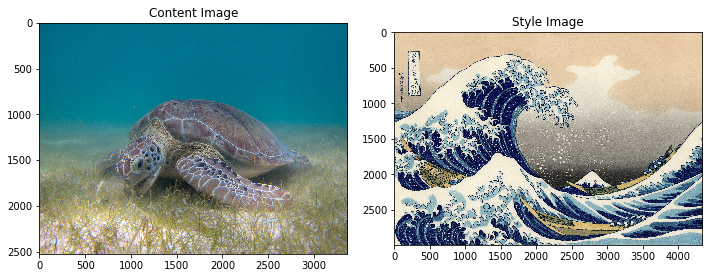

In [4]:
content = Image.open(CONTENT)
style = Image.open(STYLE)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style Image')

plt.tight_layout()
plt.show()

In [5]:
def img_parser(filename):
    img_string = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_string, channels=3)
    img = tf.cast(img, dtype=tf.float32)

    # Resize the image
    img = tf.image.resize_images(img, size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.expand_dims(img, axis=0)   # Add batch dimension
    return img

## Preprocess

We will be using VGG19 model using Transfer learning as it was done in the paper. One thing to note that we need to process our images into image preprocessing step. VGG networks( and other ImageNet models) are trained on image with each channel normalized by `mean = [103.939, 116.779, 123.68]`and with channels BGR. Although it's not a complicated function to write, it's already written in keras so we don't need to do it ourselves.

In [6]:
def load_image(filename):
    img = img_parser(filename)
    img = kr.applications.vgg19.preprocess_input(img)
    return img

In order to view the outputs of our optimization, we are required to perform the inverse preprocessing step. Also,  we must clip to maintain our values from within the 0-255 range.   

In [7]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]  # Convert back to RGB from BGR

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
_vgg = kr.applications.vgg19.VGG19(include_top=False, 
                                   weights=None, 
                                   input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
_vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_________________________________________________________________
bloc

### Define content and style representations

We will use the intermediate layers of the model to get the content and style representations of the image. 

**Why intermediate layers?**

At a high level, in order for a network to perform image classification, it must understand the image. This involves taking the raw image as input pixels and building an internal representation through transformations that turn the raw image pixels into a complex understanding of the features present within the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features. These intermediate layers are necessary to define the representation of content and style from the images. The model serves as a complex feature extractor; hence by accessing intermediate layers, we’re able to describe the content and style of input images. 

We would like the "generated" image G to have similar content as the input image C. Suppose we have chosen some layer's activations to represent the content of an image. We'll get the most visually pleasing results if we choose a layer in the middle of the network--neither too shallow nor too deep. (Feel free to experiment with using different layers, to see how the results vary.)

In [9]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

## Build the Model 

Let's create a model that will take an input image and output the content and style intermediate layers

In [10]:
def get_model(styles, contents):
    """ Creates our model with access to intermediate layers. 
    Loads the VGG19 model and access the intermediate layers. 
    These layers will then be used to create a new model that will take input image
    and return the outputs from these intermediate layers from the VGG model.
    
    Parameters:
    -----------
    styles: list
        A list containing all style layers from VGG19 model
    contents: list
        A list containing all content layers from VGG19 model

    Returns:
    --------
    VGG: kr.Model
        A keras model that takes image inputs and outputs the style and 
        content intermediate layers. 
    """
    
    vgg = kr.applications.vgg19.VGG19(include_top=False, 
                                      weights='imagenet', 
                                      input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(layer_name).output for layer_name in styles]
    content_outputs = [vgg.get_layer(layer_name).output for layer_name in contents]
    model_outputs = style_outputs + content_outputs
   
    return kr.Model(vgg.input, model_outputs)

## Losses

We will build the NST algorithm in three steps:

- Build the content loss function $L_{content}(C,G)$
- Build the style loss function $L_{style}(S,G)$
- Put it together to get $L(G) = \alpha L_{content}(C,G) + \beta L_{style}(S,G)$. 

### Content Loss

Our content loss function is actually quite simple. We will try to measure how much is the G(Generated image) and C(Content image) are similar to each other. Now, we will set the image C as the input to the pretrained VGG network, and run forward propagation. $a^{(C)}$ will be the hidden layer activations in the layer we had chosen. This will be a 3D Tensor with the shape of [H, W, C]. Then we'll repeat this process with the image G as well. Therefore $a^{(G)}$ will be the corresponding hidden layer activation. We then can define as the content loss function as:

$$L_{content}(C,G) = \sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2 $$

In [11]:
def get_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

## Style Loss

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. We will calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. 

After generating the Style matrix (Gram matrix), we will minimize the distance between the Gram matrix of the image S and image G. For now, we can derive the loss using only a single hidden layer $a^{[l]}$, and the corresponding style loss for this layer is defined as: 

$$L_{style}^{[l]}(S,G) = \sum_{i,j}(Gram^{(S)}_{ij} - Gram^{(G)}_{ij})^2 $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the style image and the generated image, computed using the hidden layer activations for a particular hidden layer in the network.

It turns out that you get more visually pleasing results if you use the style loss function from multiple different layers. So, the overall style cost function, we can define as:

$$L_{style}(S,G) = \sum_{l} \lambda^{[l]} L^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [12]:
def get_layer_style_loss(style, generated):
    def gram_matrix(tensor):
        channels = int(tensor.shape[-1])
        a = tf.reshape(tensor, [-1, channels])
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(tf.shape(a)[0], tf.float32)

    gram_style = gram_matrix(style)
    gram_generated = gram_matrix(generated)
    return tf.reduce_mean(tf.square(gram_style - gram_generated))


def get_style_loss(style, generated):
    loss = 0
    coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]
    for s, g, coeff in zip(style, generated, coeffs):
        loss += coeff * get_layer_style_loss(s, g)
    
    return loss

## Define Total Loss

This is where we will combine style and content losses together. 

$$L(G) = \alpha L_{content}(C,G) + \beta L_{style}(S,G)$$ 

In [13]:
def compute_loss(model, image, style_features, content_features, alpha=0.1, beta=0.002):
    """This function will compute the loss total loss.
  
    Parameters:
    -----------
    model: kr.Model 
        The model that will give us access to the intermediate layers
    image: Tensor
        Initial image. This is what we are updating with the optimization process. 
    style_features: Tensor
        Precomputed style features from our Style image.
    content_features: Tensor
        Precomputed content features from our Content image.
      
    Returns:
    loss: Tensor
        Returns the total loss
    """

    # Feed our init image through our model.
    model_outputs = model(image)

    content_generated = [content_layer[0] for content_layer in model_outputs[len(style_layers):]][0]
    style_generated = [style_layer for style_layer in model_outputs[:len(style_layers)]]
    
    content_loss = alpha * get_content_loss(content_features, content_generated)
    style_loss = beta * get_style_loss(style_features, style_generated)

    # Get total loss
    loss = style_loss + content_loss
    return loss

### Gradient Tape and Eager Execution

A lot of things are changing with TensorFlow 2.0 like default execution mode changing from Graph which is where we build our graph and then execute it to eager which is where the operations are executed immediately like a normal Python variable. The problem we are dealing with here is not the build a model and use it to make predictions but rather use an existing model to extract feature maps and then use them to generate a new image. What we will be doing is that using the error we calculated just now to apply it on our G image which is a noisy image or could be the content image itself. Remember we use optimizer to minimize the loss and that would train our network?. The idea behind that is that optimizer calls two function behind the minizie function:

- Compute gradients
- Apply gradients

**Compute Gradients**: This is where tensorflow helps us the most by calculating the derivaties between the output and input according to our loss function.

**Apply Gradients**: After the gradients were calculated, optimize calls this function to apply gradients to trainable variables in our graph. That's how the backpropagation works :) 

Now, back to our problem. We need to be able to retrieve to gradients and distribute them to G image to change its content. So, everything sounds fine in Graph mode but what about the eager execution mode? In eager mode, because there's no graph, the optimize can't know which values to follow and apply gradients. So we use Gradient tape to record our gradient process so then when we call the gradients function it will be okay to compute it. Now, I still wanted to make this in Graph mode by using compute gradients and apply gradients seperately but it just didn't work as I expected. So I switched to eager mode to make it work. You are welcome to give it a try. 

In [14]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        loss = compute_loss(**cfg)
    # Compute gradients with respect to input image
    return tape.gradient(loss, cfg['image']), loss

## Apply Style Transfer to Images

After the computation of gradients, we need to apply them to our G image. We will use optimizer's `apply_gradients` function to do that. Also note that, in eager mode we can't use the `tf.Variable` and we need to wrap our G image to a variable to calculate the gradients. That's why we will use the `tf.contrib.eager.Variable` to create one when in eager mode.

In [15]:
def transfer_style(content_img, style_img, epochs=1000): 
    def generate_noisy_image(content_image, noise_ratio):
        """Generates a noisy image by adding random noise to the content image"""
    
        noise_image = tf.random.uniform([1, IMAGE_HEIGHT, IMAGE_WIDTH, 3], minval=-20, maxval=20)
        input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
        return input_image

    # We don't want to train any layers of our model 
    model = get_model(style_layers, content_layers) 
    for layer in model.layers:
        layer.trainable = False
        
    S = load_image(style_img)
    C = load_image(content_img)

    style_outputs = model(S)
    content_outputs = model(C)

    # Get the style and content feature representations (from our specified intermediate layers) 
    _content = [content_layer[0] for content_layer in content_outputs[len(style_layers):]][0]
    _style = [style_layer[0] for style_layer in style_outputs[:len(style_layers)]]
  
    # Set initial image
    G = generate_noisy_image(C, 0.6)
    G = tf.contrib.eager.Variable(G, dtype=tf.float32)

    best_loss, best_img = float('inf'), None
  
    # Create a nice config 
    cfg = {
        'model': model,
        'image': G,
        'style_features': _style,
        'content_features': _content
    }
    
    # Create our optimizer
    opt = tf.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
    
    # For displaying
    display_interval = epochs/(2*5)
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grads, cost = compute_grads(cfg)
        opt.apply_gradients([(grads, G)])
        clipped = tf.clip_by_value(G, min_vals, max_vals)
        G.assign(clipped)
        
        if cost < best_loss:
            best_loss = cost
            best_img = deprocess_img(G.numpy())

        if i % display_interval== 0:
            plot_img = G.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            display.clear_output(wait=True)
            display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}, LOSS: {:.4e}'.format(i, cost))
        
            
    display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss 

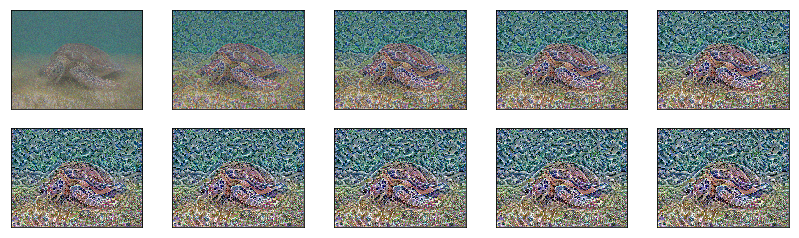

In [16]:
best, best_loss = transfer_style(CONTENT, STYLE, epochs=200)

## Visualize Outputs 

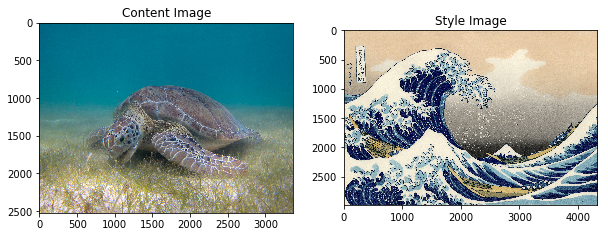

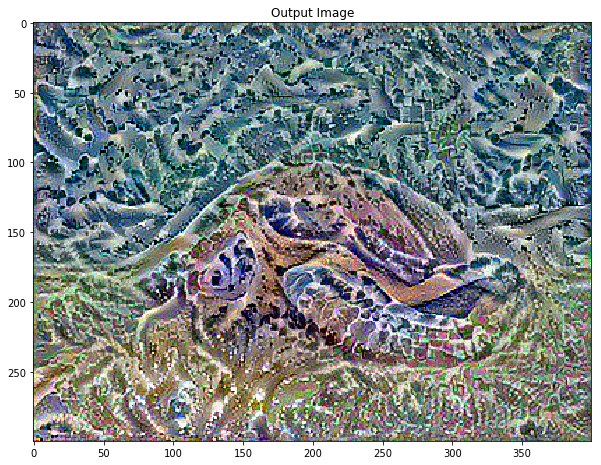

In [17]:
plt.figure(figsize=(10, 10))
content = Image.open(CONTENT) 
style = Image.open(STYLE)

plt.subplot(1, 2, 1)
plt.imshow(content)
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(style)
plt.title('Style Image')

plt.figure(figsize=(10, 10))

plt.imshow(best)
plt.title('Output Image')
plt.show()

## Conclusions

This is of course not the deployment ready code, just a basic implementation. This was inspired by the [TensorFlow Neural Style Tutorial](https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb). Last output is the interpolated version so it doesn't seem to be a high quality image but you can try to change image size in the model from 300x400 to let's say 900x900 to get better results :). Lastly, please upvote my kernel if you find it useful.